# Calcul d'une paire de dés un peu particulière.
- Je vais implémenter une fonction, en [Python 3](https://docs.python.org/3/), qui permettra de résoudre rapidement un problème mathématique.

---
## Exposé du problème :
- Soit $n \geq 1$ un nombre de faces pour des dés bien équilibrés. On prendre $n = 6$ pour commencer, mais $n = 8, 10, 12, 20$ ou $n = 100$ est aussi possible.
- On veut trouver deux ensembles d'entiers, $A$ et $B$, de tailles $n$, tels que les entiers dans $A$ soient tous [premiers](https://fr.wikipedia.org/wiki/Nombre_premier), et les entiers dans $B$ soient tous [pairs](https://fr.wikipedia.org/wiki/Parit%C3%A9_(arithm%C3%A9tique)), et on souhaite que chaque somme $a + b$ pour $a \in A$ et $b \in B$ soit encore un nombre premier.

Par exemples :
- Avec $n = 1$, prendre $A = \{3\}$ et $B = \{2\}$ fonctionne, comme $3 + 2 = 5$ est premier.
- Avec $n = 2$, prendre $A = \{3, 5\}$ et $B = \{2, 8\}$ fonctionne, comme $3 + 2 = 5$, $3 + 8 = 11$, $5 + 2 = 7$, et $5 + 8 = 13$ sont premiers.
- Avec $n = 6$, c'est tout de suite moins facile à trouver de tête... Allez, je triche et je donne un exemple trouvé plus bas : $A = \{5, 7, 17, 31, 61, 101\}$ et $B = \{6, 12, 36, 66, 96, 132\}$.

### Buts
Notre but est d'abord de trouver vérifier qu'une paire $(A, B)$ donnée soit valide, puis de trouver une paire valide de taille $n$ donnée.
On ne cherchera pas à avoir un algorithme très malin, une énumération exhaustive nous suffira.


Ensuite on cherchera à répondre à une question plus combinatoire : peut-on trouver, à $n$ fixer, la paire valide $(A, B)$ de somme minimale (ou minimisant un certain critère) ?
La réponse sera oui, et pas trop dure à obtenir.

---
## Présentation de ma solution numérique
- Je vais utiliser le module python [`sympy`](http://sympy.org/) et en particulier ses fonctions du module [`sympy.ntheory`](http://docs.sympy.org/latest/modules/ntheory.html) pour avoir facilement accès à une liste de nombres premiers. En particulier, [`primerange`](http://docs.sympy.org/latest/modules/ntheory.html#sympy.ntheory.generate.primerange) sera bien pratique.
- Je vais procéder par énumération totale avec un "doubling trick" : on cherchera toutes les paires $(A, B)$ bornées dans, disons, $[1, 100]$, puis $[1, 110]$ et ainsi de suite (avec un petit incrément), jusqu'à en trouver une qui marche.
- Cette approche "ascendante" garantit de terminer, pour peu qu'on puisse prouver théoriquement l'existence de la solution qu'on cherche.

### Solution théorique ?
> Je ne vais pas rentrer dans les détails, mais avec [le théorème de la progression arithmétique de Dirichlet](https://fr.wikipedia.org/wiki/Théorème_de_la_progression_arithmétique) (cf. aussi [ce document](http://perso.eleves.ens-rennes.fr/~ariffaut/Agregation/Dirichlet.pdf)), on peut montrer que pour tout nombre de faces $n \geq 1$, on peut trouver un nombre infini d'ensembles $(A, B)$ qui conviennent.
> *Ouais, c'est balèze*.

----
### Solution numérique
On commence avec les dépendances suivantes.

> *Note :* Si vous n'avez pas installé [`sympy`](http://sympy.org/), un simple coup de `pip install sympy` suffit.

In [1]:
from sympy import isprime
from sympy import primerange

---
## Implémentation des fonctions utilitaires requises
D'abord, une fonction `verifie_paire` qui vérifie si une paire $(A, B)$, donnée sous forme de deux *itérateurs* (liste ou ensemble, peu importe), est valide.

In [2]:
def verifie_paire(A, B):
    """Version efficace, qui s'arrête le plus tôt possible."""
    if A is None or B is None:
        return False
    for a in A:
        # if not isprime(a):  # Inutile car A aura été bien choisi
        #    return False
        for b in B:
            if not isprime(a + b):
                return False
    return True

Pour visualiser un peu, on en fait une version qui parle :

In [3]:
def verifie_paire_debug(A, B):
    """Version plus lente qui fait tous les tests, et affiche vrai ou faux pour chaque somme a + b."""
    if A is None or B is None:
        return False
    reponse = True
    for a in A:
        if not isprime(a):
            print("  - a = {:<6} est pas premier, ECHEC ...".format(a))
            reponse = False
        for b in B:
            if not isprime(a + b):
                print("  - a = {:<6} + b = {:<6} donnent {:<6} qui n'est pas premier, ECHEC ...".format(a, b, a + b))
                reponse = False
            else:
                print("  - a = {:<6} + b = {:<6} donnent {:<6} qui est bien premier, OK ...".format(a, b, a + b))
    return reponse

Premier exemple :

In [4]:
A = [3]
B = [2]
verifie_paire_debug(A, B)

  - a = 3      + b = 2      donnent 5      qui est bien premier, OK ...


True

Second exemple :

In [5]:
A = (3, 5)
B = (2, 8)
verifie_paire_debug(A, B)

  - a = 3      + b = 2      donnent 5      qui est bien premier, OK ...
  - a = 3      + b = 8      donnent 11     qui est bien premier, OK ...
  - a = 5      + b = 2      donnent 7      qui est bien premier, OK ...
  - a = 5      + b = 8      donnent 13     qui est bien premier, OK ...


True

In [6]:
verifie_paire(A, B)

True

Avec $n = 6$ :

In [7]:
A = [5, 7, 17, 31, 61, 101]
B = [6, 12, 36, 66, 96, 132]
verifie_paire(A, B)

True

Les dés vendus dans le commerce sont marqués avec ces faces :

In [4]:
A = [2, 6, 20, 252, 266, 380]
B = [17, 41, 107, 191, 311, 347]
verifie_paire(A, B)

True

---
On a besoin de cette fonction de combinaison :

In [8]:
from itertools import combinations

Ensuite, on écrit une fonction qui va énumérer *tous* les ensembles $(A, B)$ possibles et valides, avec $\max (A \cup B ) \leq M$ pour $M$ fixé.
J'ajoute une borne inférieure $m$, valant par défaut $m = 1$, pour rester le plus générique possible, mais on ne s'en sert pas vraiment.

- On récupère les candidats possibles pour $a \in A$ via `primerange` (notés $C_A$), et pour $B$ via un `range` à pas $2$ pour considérer seulement des nombres pairs (notés $B_A$),
- Ensuite on boucle sur tous les ensembles $A$ de taille $n$ dans $C_A$, et $B$ de taille $n$ dans $C_B$, via [`itertools.combinations`](https://docs.python.org/3/library/itertools.html#itertools.combinations),
- On garde uniquement ceux qui sont valides, et on les stocke tous.

> **Attention** ça devient vite très couteux !

In [9]:
def candidats_CA_CB(M=10, m=1):
    # Premiers entre m et M (compris), ie. P inter [|m, ..., M|]
    C_A = list(primerange(m, M + 1))
    # Nombres pairs
    if m % 2 == 0:
        C_B = list(range(m, M - 1, 2))
    else:
        C_B = list(range(m + 1, M - 1, 2))
    return C_A, C_B

Cette première approche est très naïve, et énormément de calculs sont dédoublés (on teste les paires $(A, B)$ en faisant plein de tests pour savoir si $a + b$ est premier, c'est couteux).

In [10]:
def enumere_toutes_les_paires(n=2, M=10, m=1, debug=False):
    C_A, C_B = candidats_CA_CB(M=M, m=m)
    if debug:
        print("C_A =", C_A)
        print("C_B =", C_B)
        print("Combinaison de n =", n, "éléments dans A =", list(combinations(C_A, n)))
        print("Combinaison de n =", n, "éléments dans B =", list(combinations(C_B, n)))
    # C_A, C_B est déjà trié, c'est cool
    all_A_B = []
    for A in combinations(C_A, n):
        if debug: print(" - A =", A)
        for B in combinations(C_B, n):
            if debug: print("     - B =", B)
            if verifie_paire(A, B):
                if debug: print("==> Une paire (A, B) de plus !")
                all_A_B.append((A, B))
    # all_A_B est aussi trié par ordre lexicographique
    return all_A_B

On peut vérifier que les exemples donnés ci-dessus sont valides, et sont en fait les plus petits :

In [11]:
n = 1
M = 10
enumere_toutes_les_paires(n, M, debug=True)

C_A = [2, 3, 5, 7]
C_B = [2, 4, 6, 8]
Combinaison de n = 1 éléments dans A = [(2,), (3,), (5,), (7,)]
Combinaison de n = 1 éléments dans B = [(2,), (4,), (6,), (8,)]
 - A = (2,)
     - B = (2,)
     - B = (4,)
     - B = (6,)
     - B = (8,)
 - A = (3,)
     - B = (2,)
==> Une paire (A, B) de plus !
     - B = (4,)
==> Une paire (A, B) de plus !
     - B = (6,)
     - B = (8,)
==> Une paire (A, B) de plus !
 - A = (5,)
     - B = (2,)
==> Une paire (A, B) de plus !
     - B = (4,)
     - B = (6,)
==> Une paire (A, B) de plus !
     - B = (8,)
==> Une paire (A, B) de plus !
 - A = (7,)
     - B = (2,)
     - B = (4,)
==> Une paire (A, B) de plus !
     - B = (6,)
==> Une paire (A, B) de plus !
     - B = (8,)


[((3,), (2,)),
 ((3,), (4,)),
 ((3,), (8,)),
 ((5,), (2,)),
 ((5,), (6,)),
 ((5,), (8,)),
 ((7,), (4,)),
 ((7,), (6,))]

In [12]:
n = 2
M = 10
enumere_toutes_les_paires(n, M, debug=True)

C_A = [2, 3, 5, 7]
C_B = [2, 4, 6, 8]
Combinaison de n = 2 éléments dans A = [(2, 3), (2, 5), (2, 7), (3, 5), (3, 7), (5, 7)]
Combinaison de n = 2 éléments dans B = [(2, 4), (2, 6), (2, 8), (4, 6), (4, 8), (6, 8)]
 - A = (2, 3)
     - B = (2, 4)
     - B = (2, 6)
     - B = (2, 8)
     - B = (4, 6)
     - B = (4, 8)
     - B = (6, 8)
 - A = (2, 5)
     - B = (2, 4)
     - B = (2, 6)
     - B = (2, 8)
     - B = (4, 6)
     - B = (4, 8)
     - B = (6, 8)
 - A = (2, 7)
     - B = (2, 4)
     - B = (2, 6)
     - B = (2, 8)
     - B = (4, 6)
     - B = (4, 8)
     - B = (6, 8)
 - A = (3, 5)
     - B = (2, 4)
     - B = (2, 6)
     - B = (2, 8)
==> Une paire (A, B) de plus !
     - B = (4, 6)
     - B = (4, 8)
     - B = (6, 8)
 - A = (3, 7)
     - B = (2, 4)
     - B = (2, 6)
     - B = (2, 8)
     - B = (4, 6)
     - B = (4, 8)
     - B = (6, 8)
 - A = (5, 7)
     - B = (2, 4)
     - B = (2, 6)
     - B = (2, 8)
     - B = (4, 6)
     - B = (4, 8)
     - B = (6, 8)


[((3, 5), (2, 8))]

On peut continuer, avec $n = 3$ et un petit majorant $M$ :

In [13]:
n = 3
M = 20
enumere_toutes_les_paires(n, M, debug=False)

[((3, 7, 13), (4, 10, 16)), ((5, 11, 17), (2, 6, 12))]

On peut continuer, avec $n = 4$ et un petit majorant $M$ :

In [14]:
n = 4
M = 40
%time enumere_toutes_les_paires(n, M, debug=False)

CPU times: user 7.41 s, sys: 0 ns, total: 7.41 s
Wall time: 7.41 s


[((3, 7, 13, 37), (4, 10, 16, 34)),
 ((7, 11, 17, 31), (6, 12, 30, 36)),
 ((7, 13, 19, 37), (4, 10, 24, 34)),
 ((7, 13, 31, 37), (6, 10, 16, 30)),
 ((7, 17, 23, 37), (6, 24, 30, 36))]

On voit que ça commence à prendre du temps.

Deux améliorations seront explorées :
- On a pas besoin de toutes les calculer, en fait. Si on cherche juste une paire valide, on peut s'arrêter à la première trouvée.
- On peut être malin dans la création des candidats $C_B$, plutôt que de juste prendre de nombres pairs, on prend directement des nombres $b$ tels que $a + b$ soit premier.

---
## Première optimisation
- On n'a pas besoin d'énunumérer toutes les paires, il suffit de donner la premier trouvée.
- Pourquoi la première ? Et bien si $C_A$ et $C_B$ sont triés, les candidats pour $(A, B)$ seront aussi triés par ordre lexicographique, et donc le premier trouvé sera le plus petit.

In [15]:
def premiere_paire(n=2, M=10, m=1):
    C_A, C_B = candidats_CA_CB(M=M, m=m)
    # C_A, C_B est déjà trié, c'est cool
    for A in combinations(C_A, n):
        for B in combinations(C_B, n):
            if verifie_paire(A, B):
                return (A, B)
    return (None, None)

In [16]:
n = 4
M = 40
%time A, B = premiere_paire(n, M)
print("A =", A)
print("B =", B)

CPU times: user 2 s, sys: 8 ms, total: 2.01 s
Wall time: 2.01 s
A = (3, 7, 13, 37)
B = (4, 10, 16, 34)


Avec $n = 5$, on commence à avoir besoin d'aller plus loin que ce majorant `M = 40` :

In [17]:
n = 5
M = 40
%time A, B = premiere_paire(n, M)  # (None, None) indique qu'on a pas trouvé
print("A =", A)
print("B =", B)

CPU times: user 33.7 s, sys: 0 ns, total: 33.7 s
Wall time: 33.7 s
A = None
B = None


Mais parfois on ne sait pas trop quelle valeur donner à ce majorant `M`...

Une approche simple est donc d'augmenter sa valeur jusqu'à trouver une paire valide.

In [18]:
def premiere_paire_explore_M(n=2, Ms=[10,20,30,40,50], m=1):
    for M in Ms:
        resultat = premiere_paire(n=n, M=M, m=m)
        if resultat[0] is not None:
            return resultat
    return (None, None)

On peut faire encore mieux, en augmentant `M` automatiquement d'un certain offset $\delta_M > 0$ :

In [19]:
def premiere_paire_augmente_M(n=2, Mmin=10, deltaM=10, m=1):
    assert isinstance(deltaM, int)
    assert deltaM >= 1
    M = Mmin
    while True:
        print("Appel à premiere_paire(n={}, M={}, m={}) ...".format(n, M, m))
        # Ce n'est pas dangereux, puisqu'on est garanti de trouver une paire qui marche 
        resultat = premiere_paire(n=n, M=M, m=m)
        if resultat[0] is not None:
            print("Terminé, avec M =", M)
            return resultat
        M += deltaM

On peut retrouver le résultat trouvé plus haut, pour $n = 2$ :

In [20]:
n = 2
Ms = [10,20,30,40,50]
%time A, B = premiere_paire_explore_M(n, Ms)
print("A =", A)
print("B =", B)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 331 µs
A = (3, 5)
B = (2, 8)


In [21]:
n = 4
M = 40
deltaM = 10
%time A, B = premiere_paire_augmente_M(n=n, Mmin=M, deltaM=deltaM)
print("A =", A)
print("B =", B)

Appel à premiere_paire(n=4, M=40, m=1) ...
Terminé, avec M = 40
CPU times: user 2.01 s, sys: 0 ns, total: 2.01 s
Wall time: 2.01 s
A = (3, 7, 13, 37)
B = (4, 10, 16, 34)


Et on peut résoudre pour $n = 5$ et $n = 6$. Mais cette approche prend beaucoup trop de temps.

In [22]:
n = 5
M = 100
deltaM = 10
#%time A, B = premiere_paire_augmente_M(n=n, Mmin=M, deltaM=deltaM)
#print("A =", A)
#print("B =", B)

> *Note :* Plutôt que d'écrire une fonction (qui `return` le premier résultat), on peut aussi écrire un **générateur**, qui `yield` les résultats un à un.
> Il sera alors possible d'écrire des boucles directement comme ça :

```python
for (A, B) in generateur_paires(n=2, M=10, m=1):
    ...
```

In [23]:
def generateur_paires(n=2, M=10, m=1):
    C_A, C_B = candidats_CA_CB(M=M, m=m)
    # C_A, C_B est déjà trié, c'est cool
    for A in combinations(C_A, n):
        for B in combinations(C_B, n):
            if verifie_paire(A, B):
                yield (A, B)

---
## Exemples

---
### Exemple avec des dés à 6 faces

In [24]:
n = 6
M = 100
#A, B = premiere_paire(n, M)
#print("A =", A)
#print("B =", B)

---
## Autre approche, deuxième optimisation
On a vu que l'approche *naïve* exposée ci-dessus n'est vraiment pas très efficace.

On va être plus malin :
- d'abord générer toutes paires $(a, b)$ possibles, avec $a$ et $a + b$ premiers, pour $a, b \geq M$.
- ensuite on pourra créer la plus grande paire $(A, B)$, probablement en regardant simplement des intersections d'ensembles.

### Préliminaire : petite optimisation pour `isprime`
En une seule ligne, on peut ajouter un cache ([`functools.lru_cache`](https://docs.python.org/3/library/functools.html#functools.lru_cache)) pour la rendre plus rapide :

In [25]:
from functools import lru_cache

@lru_cache(maxsize=1<<10, typed=False)
def estpremier(n):
    return isprime(n)

@lru_cache(maxsize=1<<20, typed=False)
def candidats_CA_CB_cache(M=10, m=1):
    return candidats_CA_CB(M=M, m=m)

In [26]:
import numpy.random as nr
%timeit [isprime(n) for n in nr.randint(1, 1<<10, 100000)]

1 loop, best of 3: 208 ms per loop


In [27]:
%timeit [estpremier(n) for n in nr.randint(1, 1<<10, 100000)]

10 loops, best of 3: 18.7 ms per loop


### Générer les paires $(a, b)$ valides
C'est assez rapide.
- La première fonction renvoie le résultat sous forme de liste de paires $(a, b)$ avec $b$ tel que $a + b$ soit premier,
- La seconde fonction renvoie plutôt un dictionnaire qui, à $a \in C_A$, associe tous les $b \in C_B$ tels que $a + b$.

In [28]:
def genere_paires(M=10, m=1):
    C_A, C_B = candidats_CA_CB_cache(M=M, m=m)
    return [(a, b) for a in C_A for b in C_B if estpremier(a + b)]
    
def genere_dict(M=10, m=1):
    C_A, C_B = candidats_CA_CB_cache(M=M, m=m)
    return {a: [b for b in C_B if estpremier(a + b)] for a in C_A}

In [29]:
genere_paires(10)

[(3, 2), (3, 4), (3, 8), (5, 2), (5, 6), (5, 8), (7, 4), (7, 6)]

In [30]:
genere_dict(10)

{2: [], 3: [2, 4, 8], 5: [2, 6, 8], 7: [4, 6]}

On voit que le nombres de paires $(a, b)$ telle que $a + b$ soit premier et $a, b \leq M$ augmente assez vite avec $M$ :

In [31]:
len(genere_paires(400))

5107

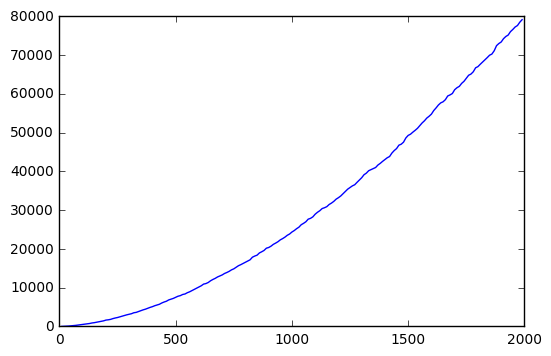

In [32]:
import matplotlib.pyplot as plt
X = list(range(10, 2000, 10))
Y = [ len(genere_paires(M)) for M in X ]
plt.plot(X, Y)
plt.show()

## Suite : générer une paire $(A, B)$
- On génère les candidats $C_A, C_B$,
- On associe à chaque $a \in C_A$ les $b \in C_B$ qui fonctionne, notés $d(a)$,
- On garde ceux qui ont au moins $n$ valeurs associées,
- On regarde tous les ensembles $A \subset C_A$ de taille exactement $n$,
- Pour un $A$ donné, on construit $B$ comme $\bigcap_{a \in A} d(a)$, et on garde les $B$ de taille $\geq n$,
- On regarde enfin tous les ensembles $B' \subset B$ de taille exactement $n$.
- Ici, on garde juste le premier trouvé, plus bas on les garde tous.

In [33]:
@lru_cache(maxsize=1<<10, typed=False)
def genere_A_B(n=2, M=10, m=1):
    C_A, C_B = candidats_CA_CB_cache(M=M, m=m)
    dictAB = {a: {b for b in C_B if estpremier(a + b)} for a in C_A}
    for a in C_A:
        if len(dictAB[a]) < n:
            del dictAB[a]
    # print(dictAB)
    C_A = sorted(list(dictAB.keys()))
    # C_A est déjà trié, c'est cool
    # TODO : This for loop could possibly get parallelized, using joblib.Parallel
    # It could speed up the computation by a factor of cpu_count()...
    for A in combinations(C_A, n):
        # DONE : improve this step to stop as soon as the intersection has length < n
        # B = set.intersection(*(dictAB[a] for a in A))
        B = set(dictAB[A[0]])
        for a in A[1:]:
            if len(B) < n:
                break
            B &= dictAB[a]
        if len(B) >= n:
            print(" - A =", A, "\t et B =", B, "...")
            for BB in combinations(B, n):  # On prend la 1ère
                return (list(A), list(BB))
    return (None, None)

In [34]:
def test_genere_AB(n=2, M=10, m=1):
    A, B = genere_A_B(n=n, M=M)
    if not verifie_paire(A, B):
        print("Mauvaise paire (A, B) =", (A, B), ": elle n'est pas valable.")
        return (None, None)
    print("A =", A)
    print("B =", B)
    return (A, B)

In [35]:
n = 2
M = 10
test_genere_AB(n=n, M=M)

 - A = (3, 5) 	 et B = {8, 2} ...
A = [3, 5]
B = [8, 2]


([3, 5], [8, 2])

In [36]:
n = 3
M = 40
%time test_genere_AB(n=n, M=M)

 - A = (3, 5, 11) 	 et B = {8, 2, 26} ...
A = [3, 5, 11]
B = [8, 2, 26]
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.8 ms


([3, 5, 11], [8, 2, 26])

In [37]:
n = 4
M = 50
%time test_genere_AB(n=n, M=M)

 - A = (3, 7, 13, 19) 	 et B = {40, 34, 10, 4} ...
A = [3, 7, 13, 19]
B = [40, 34, 10, 4]
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.89 ms


([3, 7, 13, 19], [40, 34, 10, 4])

On peut comparer cette nouvelle fonction avec `premiere_paire` écrite plus haut :

In [38]:
n = 4
M = 50
%timeit -n1 premiere_paire(n=n, M=M)

1 loop, best of 3: 10.3 s per loop


In [39]:
n = 4
M = 50
%timeit -n1 genere_A_B(n=n, M=M)

1 loop, best of 3: 1.12 µs per loop


→ On est effectivement bien plus rapide. Yay.

In [40]:
n = 5
M = 100
%time test_genere_AB(n=n, M=M)

 - A = (3, 7, 13, 19, 97) 	 et B = {40, 34, 10, 4, 94} ...
A = [3, 7, 13, 19, 97]
B = [40, 34, 10, 4, 94]
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.67 ms


([3, 7, 13, 19, 97], [40, 34, 10, 4, 94])

In [41]:
n = 6
M = 100
%time test_genere_AB(n=n, M=M)

 - A = (7, 13, 31, 37, 73, 97) 	 et B = {66, 6, 10, 76, 16, 30} ...
A = [7, 13, 31, 37, 73, 97]
B = [66, 6, 10, 76, 16, 30]
CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 110 ms


([7, 13, 31, 37, 73, 97], [66, 6, 10, 76, 16, 30])

On peut vérifier que la valeur du majorant $M$ sur les valeurs des faces ne change pas le premier $A$ trouvé, mais comme les $B$ ne sont **pas** parcourus dans un ordre lexicographique (les `set` sont non triés), on ne trouve pas le même $B$.
Et plus $M$ est grand, plus c'est long à calculer.

In [42]:
n = 6
M = 200
%time test_genere_AB(n=n, M=M)

 - A = (3, 7, 13, 31, 73, 97) 	 et B = {160, 100, 40, 10, 76, 16} ...
A = [3, 7, 13, 31, 73, 97]
B = [160, 100, 40, 10, 76, 16]
CPU times: user 248 ms, sys: 0 ns, total: 248 ms
Wall time: 246 ms


([3, 7, 13, 31, 73, 97], [160, 100, 40, 10, 76, 16])

Ça marche plutôt bien, on trouve effectivement la paire qui possède le plus petit $\max A$ mais pas celle qui minimise $\sum A \cup B$ ou $\max A \cup B$...

## Trouver la paire de somme minimale ou de max minimum.
- On va calculer *toutes* les paires, avec notre fonction optimisée, dans `genere_toutes_A_B`,
- Puis on les triera (en ordre croissant) selon le critère voulu,
- Et on renvoie la première, qui minimisera donc le critère cherché.

> *Note :* en étant malin, on pourrait carrément faire mieux qu'une énumération complète. Mais la flemme.

### D'abord, générer toutes les paires $(A, B)$
C'est la même fonction que `genere_A_B`, mais on les renvoie toutes au lieu de s'arrêter à la première.

In [43]:
@lru_cache(maxsize=1<<10, typed=False)
def genere_toutes_A_B(n=2, M=10, m=1):
    C_A, C_B = candidats_CA_CB_cache(M=M, m=m)
    dictAB = {a: {b for b in C_B if estpremier(a + b)} for a in C_A}
    for a in C_A:
        if len(dictAB[a]) < n:
            del dictAB[a]
    # print(dictAB)
    C_A = sorted(list(dictAB.keys()))
    # C_A est déjà trié, c'est cool
    paires = []
    # TODO : This for loop could very easily get parallelized, using joblib.Parallel
    # It could speed up the computation by a factor of cpu_count()...
    for A in combinations(C_A, n):
        # DONE : improve this step to stop as soon as the intersection has length < n
        # B = set.intersection(*(dictAB[a] for a in A))
        B = set(dictAB[A[0]])
        for a in A[1:]:
            if len(B) < n:
                break
            B &= dictAB[a]
        if len(B) >= n:
            for BB in combinations(B, n):
                print(" - A =", A, "\t et B =", B, "...")
                # print('.', end='')  # Affiche .... au fur et à mesure de l'exécution.
                paires.append((list(A), list(BB)))
    print('')
    return paires

On vérifie que ça fonctionne comme prévu :

In [44]:
n = 4
M = 40
genere_toutes_A_B(n=n, M=M)

 - A = (3, 7, 13, 37) 	 et B = {16, 34, 10, 4} ...
 - A = (7, 11, 17, 31) 	 et B = {36, 12, 6, 30} ...
 - A = (7, 13, 19, 37) 	 et B = {24, 34, 10, 4} ...
 - A = (7, 13, 31, 37) 	 et B = {16, 10, 6, 30} ...
 - A = (7, 17, 23, 37) 	 et B = {24, 36, 6, 30} ...



[([3, 7, 13, 37], [16, 34, 10, 4]),
 ([7, 11, 17, 31], [36, 12, 6, 30]),
 ([7, 13, 19, 37], [24, 34, 10, 4]),
 ([7, 13, 31, 37], [16, 10, 6, 30]),
 ([7, 17, 23, 37], [24, 36, 6, 30])]

Il suffit donc de trier selon le critère choisi.
$$
    \mathrm{sumsum} : (A, B) \mapsto \sum_{a \in A} a + \sum_{b \in B} b.
$$
$$
    \mathrm{maxmax} : (A, B) \mapsto \max A \cup B.
$$

In [45]:
def sumsum(paire):
    return sum(paire[0]) + sum(paire[1])

def maxmax(paire):
    return max(max(paire[0]), max(paire[1]))

On peut aussi prendre un critère qui combine les deux :

In [46]:
def combine(paire):
    return (sumsum(paire) + maxmax(paire)) / 2

Il suffit d'utiliser l'argument `key=` de la fonction [`sorted`](https://docs.python.org/3/library/functions.html#sorted) :

In [47]:
def trie_et_prend_min(paires, key=sumsum):
    paires = sorted(paires, key=key)
    A, B = paires[0]
    assert verifie_paire(A, B)
    return (sorted(A), sorted(B))

Pour tester :

In [48]:
def test_trie_et_prend_min(n=2, M=10):
    paires = genere_toutes_A_B(n=n, M=M)
    print("Pour n =", n, "et M =", M, "il y a", len(paires), "paires (A, B) trouvées valides ...")

    print("- On recherche celle de somme sum(A u B) minimale ...")
    A, B = trie_et_prend_min(paires, key=sumsum)
    print("A =", A)
    print("B =", B)
    print("  Elle donne sumsum =", sumsum((A, B)), "et maxmax =", maxmax((A, B)))

    print("- On recherche celle de maximum max(A u B) minimale ...")
    A, B = trie_et_prend_min(paires, key=maxmax)
    print("A =", A)
    print("B =", B)
    print("  Elle donne sumsum =", sumsum((A, B)), "et maxmax =", maxmax((A, B)))

    print("- On recherche celle de moyenne sumsum(A,B), maxmax(A,B) minimale ...")
    A, B = trie_et_prend_min(paires, key=combine)
    print("A =", A)
    print("B =", B)
    print("  Elle donne sumsum =", sumsum((A, B)), "et maxmax =", maxmax((A, B)))
    
    # for key in [sumsum, maxmax, combine]:
    #    alls = [ (key(paire), (sorted(paire[0]), sorted(paire[1]))) for paire in sorted(paires, key=key) ]
    #    print(alls[:5])
    return (A, B)

On peut refaire les mêmes exemples pour $n = 3, 4, 5$, et enfin $n = 6$.

In [49]:
n = 3
M = 20
test_trie_et_prend_min(n, M)

 - A = (3, 7, 13) 	 et B = {16, 10, 4} ...
 - A = (5, 11, 17) 	 et B = {2, 12, 6} ...

Pour n = 3 et M = 20 il y a 2 paires (A, B) trouvées valides ...
- On recherche celle de somme sum(A u B) minimale ...
A = [3, 7, 13]
B = [4, 10, 16]
  Elle donne sumsum = 53 et maxmax = 16
- On recherche celle de maximum max(A u B) minimale ...
A = [3, 7, 13]
B = [4, 10, 16]
  Elle donne sumsum = 53 et maxmax = 16
- On recherche celle de moyenne sumsum(A,B), maxmax(A,B) minimale ...
A = [3, 7, 13]
B = [4, 10, 16]
  Elle donne sumsum = 53 et maxmax = 16


([3, 7, 13], [4, 10, 16])

In [50]:
n = 4
M = 37
test_trie_et_prend_min(n, M)

 - A = (3, 7, 13, 37) 	 et B = {16, 34, 10, 4} ...
 - A = (7, 13, 19, 37) 	 et B = {24, 34, 10, 4} ...
 - A = (7, 13, 31, 37) 	 et B = {16, 10, 6, 30} ...

Pour n = 4 et M = 37 il y a 3 paires (A, B) trouvées valides ...
- On recherche celle de somme sum(A u B) minimale ...
A = [3, 7, 13, 37]
B = [4, 10, 16, 34]
  Elle donne sumsum = 124 et maxmax = 37
- On recherche celle de maximum max(A u B) minimale ...
A = [3, 7, 13, 37]
B = [4, 10, 16, 34]
  Elle donne sumsum = 124 et maxmax = 37
- On recherche celle de moyenne sumsum(A,B), maxmax(A,B) minimale ...
A = [3, 7, 13, 37]
B = [4, 10, 16, 34]
  Elle donne sumsum = 124 et maxmax = 37


([3, 7, 13, 37], [4, 10, 16, 34])

In [51]:
n = 5
M = 70
test_trie_et_prend_min(n, M)

 - A = (5, 11, 17, 41, 47) 	 et B = {6, 42, 12, 56, 26, 62} ...
 - A = (5, 11, 17, 41, 47) 	 et B = {6, 42, 12, 56, 26, 62} ...
 - A = (5, 11, 17, 41, 47) 	 et B = {6, 42, 12, 56, 26, 62} ...
 - A = (5, 11, 17, 41, 47) 	 et B = {6, 42, 12, 56, 26, 62} ...
 - A = (5, 11, 17, 41, 47) 	 et B = {6, 42, 12, 56, 26, 62} ...
 - A = (5, 11, 17, 41, 47) 	 et B = {6, 42, 12, 56, 26, 62} ...
 - A = (5, 17, 29, 47, 59) 	 et B = {24, 42, 12, 54, 14} ...
 - A = (5, 17, 31, 47, 61) 	 et B = {66, 12, 42, 36, 6} ...
 - A = (7, 13, 37, 43, 67) 	 et B = {16, 4, 30, 46, 60} ...
 - A = (11, 13, 23, 41, 53) 	 et B = {48, 18, 60, 6, 30} ...
 - A = (11, 17, 23, 47, 53) 	 et B = {56, 50, 36, 20, 6} ...

Pour n = 5 et M = 70 il y a 11 paires (A, B) trouvées valides ...
- On recherche celle de somme sum(A u B) minimale ...
A = [5, 11, 17, 41, 47]
B = [6, 12, 26, 42, 56]
  Elle donne sumsum = 263 et maxmax = 56
- On recherche celle de maximum max(A u B) minimale ...
A = [5, 11, 17, 41, 47]
B = [6, 12, 26, 42, 56]

([5, 11, 17, 41, 47], [6, 12, 26, 42, 56])

On observe que celle qui minimise `sumsum` est la même que celle qui minimise `maxmax`. Curieux ?

C'est aussi le cas pour $n = 6$ :

In [52]:
n = 6
M = 150
%time test_trie_et_prend_min(n, M)

 - A = (3, 7, 13, 37, 73, 97) 	 et B = {34, 100, 10, 76, 16, 94} ...
 - A = (5, 7, 17, 31, 61, 101) 	 et B = {96, 66, 132, 36, 6, 12} ...
 - A = (5, 11, 17, 41, 71, 137) 	 et B = {96, 2, 42, 12, 56, 26} ...
 - A = (5, 11, 17, 41, 101, 137) 	 et B = {96, 2, 12, 56, 26, 62} ...
 - A = (5, 11, 17, 47, 71, 137) 	 et B = {36, 42, 12, 56, 26, 92} ...
 - A = (5, 11, 17, 47, 101, 137) 	 et B = {36, 12, 56, 26, 92, 62} ...
 - A = (5, 11, 17, 47, 131, 137) 	 et B = {36, 42, 146, 26, 92, 62} ...
 - A = (5, 11, 17, 71, 101, 137) 	 et B = {96, 2, 36, 12, 56, 26, 92} ...
 - A = (5, 11, 17, 71, 101, 137) 	 et B = {96, 2, 36, 12, 56, 26, 92} ...
 - A = (5, 11, 17, 71, 101, 137) 	 et B = {96, 2, 36, 12, 56, 26, 92} ...
 - A = (5, 11, 17, 71, 101, 137) 	 et B = {96, 2, 36, 12, 56, 26, 92} ...
 - A = (5, 11, 17, 71, 101, 137) 	 et B = {96, 2, 36, 12, 56, 26, 92} ...
 - A = (5, 11, 17, 71, 101, 137) 	 et B = {96, 2, 36, 12, 56, 26, 92} ...
 - A = (5, 11, 17, 71, 101, 137) 	 et B = {96, 2, 36, 12, 56, 26, 

([7, 13, 31, 37, 73, 97], [6, 10, 16, 30, 66, 76])

In [53]:
A, B = test_trie_et_prend_min(n, M)
verifie_paire_debug(A, B)

Pour n = 6 et M = 150 il y a 109 paires (A, B) trouvées valides ...
- On recherche celle de somme sum(A u B) minimale ...
A = [7, 13, 31, 37, 73, 97]
B = [6, 10, 16, 30, 66, 76]
  Elle donne sumsum = 462 et maxmax = 97
- On recherche celle de maximum max(A u B) minimale ...
A = [7, 13, 31, 37, 73, 97]
B = [6, 10, 16, 30, 66, 76]
  Elle donne sumsum = 462 et maxmax = 97
- On recherche celle de moyenne sumsum(A,B), maxmax(A,B) minimale ...
A = [7, 13, 31, 37, 73, 97]
B = [6, 10, 16, 30, 66, 76]
  Elle donne sumsum = 462 et maxmax = 97
  - a = 7      + b = 6      donnent 13     qui est bien premier, OK ...
  - a = 7      + b = 10     donnent 17     qui est bien premier, OK ...
  - a = 7      + b = 16     donnent 23     qui est bien premier, OK ...
  - a = 7      + b = 30     donnent 37     qui est bien premier, OK ...
  - a = 7      + b = 66     donnent 73     qui est bien premier, OK ...
  - a = 7      + b = 76     donnent 83     qui est bien premier, OK ...
  - a = 13     + b = 6      d

True

## Conclusion pour des dés à $6$ faces
Avec $n = 6$ dés, la plus petite paire de valeurs $(A, B)$ trouvée est 
- A = $\{7, 13, 31, 37, 73, 97\}$
- B = $\{6, 10, 16, 30, 66, 76\}$

Elle donne $\sum A \cup B = 462$ et $\max A \cup B = 97$.

Assez surprenament, c'est la paire qui minimise les deux critères à la fois (et l'unique paire qui satisfait cette propriété).

---
## Avec plus de faces ?

### Exemples avec des dés à 8, 10, 12 et 20 faces
> Ça va commencer à être *très couteux*. Je recommande de ne pas faire tourner ce code sur votre machine, mais sur un serveur de calcul, par exemple !

In [54]:
n = 7
M = 170
%time test_genere_AB(n=n, M=M)
%time test_trie_et_prend_min(n, M)

 - A = (3, 7, 13, 37, 73, 97, 157) 	 et B = {160, 34, 100, 10, 76, 16, 94} ...
A = [3, 7, 13, 37, 73, 97, 157]
B = [160, 34, 100, 10, 76, 16, 94]
CPU times: user 704 ms, sys: 12 ms, total: 716 ms
Wall time: 713 ms
 - A = (3, 7, 13, 37, 73, 97, 157) 	 et B = {160, 34, 100, 10, 76, 16, 94} ...
 - A = (3, 13, 19, 37, 79, 97, 103) 	 et B = {160, 34, 4, 70, 10, 154, 94} ...
 - A = (3, 13, 37, 73, 97, 157, 163) 	 et B = {34, 100, 10, 76, 16, 154, 94} ...
 - A = (7, 13, 31, 37, 73, 97, 157) 	 et B = {160, 66, 100, 6, 10, 76, 16} ...
 - A = (7, 13, 31, 67, 73, 97, 151) 	 et B = {160, 100, 166, 6, 40, 16, 30} ...
 - A = (7, 13, 37, 73, 97, 157, 163) 	 et B = {34, 66, 100, 10, 76, 16, 94} ...
 - A = (13, 17, 23, 73, 83, 107, 167) 	 et B = {66, 6, 84, 150, 24, 90, 30} ...
 - A = (13, 19, 37, 79, 97, 103, 163) 	 et B = {34, 4, 70, 10, 154, 60, 94} ...

Pour n = 7 et M = 170 il y a 8 paires (A, B) trouvées valides ...
- On recherche celle de somme sum(A u B) minimale ...
A = [7, 13, 31, 37, 73, 97,

([7, 13, 31, 37, 73, 97, 157], [6, 10, 16, 66, 76, 100, 160])

#### Avec 8 faces

In [55]:
n = 8
M = 440
%time test_genere_AB(n=n, M=M)
# %time test_trie_et_prend_min(n, M)

AssertionError: 

#### Avec 10 faces

In [ ]:
n = 10
M = 550
%time test_genere_AB(n=n, M=M)
# %time test_trie_et_prend_min(n, M)

#### Avec 12 faces

In [ ]:
n = 12
M = 800
%time test_genere_AB(n=n, M=M)
# %time test_trie_et_prend_min(n, M)

#### Avec 20 faces

In [ ]:
n = 20
M = 1000
%time test_genere_AB(n=n, M=M)
# %time test_trie_et_prend_min(n, M)

### Exemples avec des dés de tailles différentes
> Il ne serait pas très compliqué d'adapter le code précédent pour considérer $A$ de taille $n$ et $B$ de taille $p$ avec possiblement $n \neq p$.
> Je le ferai, plus tard.

### Exemples avec $100$ faces ?
> Il faudrait une machine costaux, et du temps...

----
# Généralisations possibles
- Dés avec un nombre de faces différentes, i.e., $\# A \neq \# B$,
- Plus de deux dés, i.e., considérer $A_1, \dots, A_p$ et chercher la même propriété :
  $$ \forall a_1 \in A_1, \dots, a_p \in A_p, a_1 + \dots + a_p \in \mathcal{P}. $$
  En imposant toujours que $A_1 \subset \mathcal{P}$, et éventuellement plus.
- Résoudre autrement le problème initial pour ne pas avoir à donner une borné $M$ sur $\max A, B$.